# Geodatenanalyse 2: Bayesische Hyperparameteroptimierung und Ensemble-Modellierung

Ziel der Übung: Für das Modell aus dem Termin zur Zeitreihenvorhersage von Grundwasserständen sollen Hyperparameter optimiert werden. Wir möchten die optimale die Länge der Inputsequenz sowie der Anzahl der Units im LSTM Layer optimieren. 

Weiterhin minimieren wir den Einfluss der Modellinitialisierung (basierend auf einer Zufallszahl) durch ein Ensemble welches mehrere definierte *random number seeds* nutzt. 

Zunächst nutzen wir Zellen des Notebooks vom letzten Termin.

### set random seed
Um ein reproduzierbares Ergebnis zu erhalten definieren wir zunächst die Startpunkte (seeds) der Zufallszahlengeneratoren von numpy und tensorflow:

In [1]:
#set random seed for reproducability
from numpy.random import seed
seed(347824) # this is a randomly chosen number

from tensorflow import random
random.set_seed(63494) # this is also a randomly chosen number

print("seeds are set")

seeds are set


### load data
Die (wöchentlich) Grundwasserdaten befinden sich in der Datei: **GW-Data.csv**  
Die meteorologischen Inputdaten in der Datei: **Climate-Data.csv**

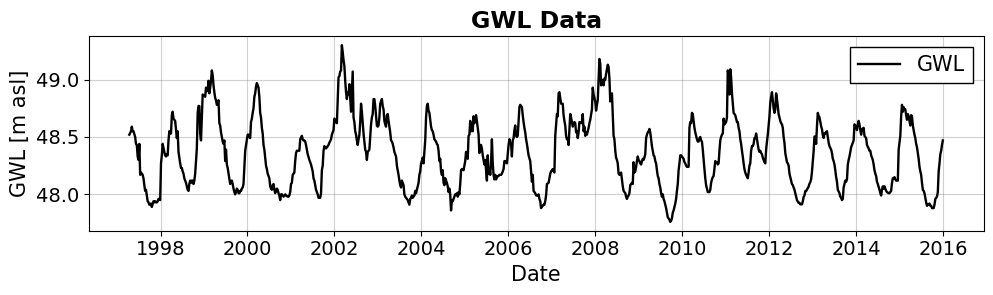

,GWL,P,rH,T,Tsin
Date,,,,,
1997-04-14,48.520,1.203046,62.731979,6.593939,-1.439494
1997-04-21,48.535,0.864522,61.926402,4.493416,-0.347873
1997-04-28,48.550,7.486455,62.071464,9.000969,0.748794
1997-05-05,48.590,30.453424,80.260318,11.661238,1.834601
1997-05-12,48.550,15.360879,71.335400,10.898702,2.893801


In [2]:
import pandas as pd
import numpy as np

GWData = pd.read_csv('./GW-Data.csv',
                     parse_dates=['Date'], # hiermit werden Zeitangaben als Datum erkannt
                     index_col=0, # definiert welche Spalte der gelesenen Daten als Index für den DataFrame dienen soll
                     dayfirst = True, # definiert das Datumsformat 
                     decimal = '.', sep=',') # Angaben welche Trennzeichen in der Datei verwendet werden

ClimateData = pd.read_csv('Climate-Data.csv', 
                          parse_dates=['Date'],index_col=0,dayfirst = True,
                          decimal = '.', sep=',')

# Beide DataFrames zusammenführen
data = pd.merge(GWData, ClimateData, how='inner', left_index = True, right_index = True) # beide DataFrames zusammenführen

import matplotlib.pyplot as plt

#plot GWL data
plt.figure(figsize=(10,3))
plt.plot(data.index,data['GWL'], 'k', label ="GWL", linewidth = 1.7)
plt.title("GWL Data", size=17,fontweight = 'bold')
plt.ylabel('GWL [m asl]', size=15)
plt.xlabel('Date',size=15)
plt.legend(fontsize=15,loc='upper right',fancybox = False, framealpha = 1, edgecolor = 'k')
plt.tight_layout()
plt.grid(visible=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#inspect the data
data.head()

Der DataFrame setzt sich nun zusammen aus der Indexspalte **Date**, dem Grundwasserstand **GWL**, Niederschlag **P**, relativer Feuchte **rH**, Temperatur **T** und einem geglätteten Temperatursignal **Tsin** (Sinuskurve an T gefittet).  

Parameter **rH** und **Tsin** werden zunächst nicht benötigt (*drop*).

In [3]:
try: 
    data = data.drop(columns=['rH','Tsin'])
    print("dropped")
except: 
    print("already dropped")

dropped


we are using sequence models!
   
Wir definieren wir eine Funktion die genau das für uns erledigt und die wir immer wieder verwenden können: *make_sequences*    

Diese können wir nachher mit folgender Zeile aufrufen:  
*X,Y = make_sequences(data, n_steps_in)*

Inhaltlich passiert folgendes:

Aus einer Zeitreihe aus Inputdaten X und Zieldaten Y:  
    
    XXXXXXXXXXXXXXX  
    YYYYYYYYYYYYYYY  

werden kleine Schnipsel die jeder Inputsequenz der Länge *n_steps_in* (hier = 4) ein Zielwert zuordnet

    XXXXY
     XXXXY
      XXXXY
       XXXXY
        XXXXY
         XXXXY
          XXXXY
          ...


In [4]:
def make_sequences(data, n_steps_in):
#     """
#     data: numpy array with target (Y) in first column and model inputs in following columns
#     n_steps_in: number that defines the sequence length
    
#     Output:
#     X: sequenced model input data
#     Y: sequenced model target data
    
#     function modified after: machinelearningmastery.com
#     """
    
    #sequence the data
    X, Y = list(), list()
    # step over the entire history one time step at a time
    for i in range(len(data)):
        # find the end of this pattern
        end_idx = i + n_steps_in
        # check if we are beyond the dataset
        if end_idx >= len(data):
            break
        # gather input and output parts of the pattern
        seq_x = data[i:end_idx, 1:]
        seq_y = data[end_idx, 0]
        X.append(seq_x)
        Y.append(seq_y)
        
    return np.array(X), np.array(Y)


### split data (diesmal in 4! Teile)

Bevor wir die Daten in Sequenzen umwandeln, müssen wir aber zunächst noch den bekannten Train-Test-Split durchführen und die Daten anschließend skalieren. Wichtig, KEIN shuffling!

Da wir eine Optimierungsfunktion nutzen und data leakage ins testset vermeiden möchten, brauchen wir diesmal 4 Teile unserer Daten.
  
**Training, Early Stopping (Validation), Optimierungs und Testing**  

Wir nutzen folgende Aufeilung:
* Test: >= 2012  
* Optimierung: 2011  
* Early Stopping: 2010  
* Training: < 2010  

In [5]:
val_startdate = pd.to_datetime('01012010', format='%d%m%Y')
opt_startdate = pd.to_datetime('01012011', format='%d%m%Y')
test_startdate = pd.to_datetime('01012012', format='%d%m%Y')

#print dates
print("Start Stopset:\n{}\n\nStart Optset:\n{}\n\nStart Testset:\n{}".format(val_startdate,opt_startdate,test_startdate))

#Hier teilen wir die Daten, lassen sie aber noch nicht überlappen(!), dies ist von n_steps_in abhängig, welches wir noch nicht definiert haben

TrainingData = data[(data.index < val_startdate)] 
StopData = data[(data.index >= val_startdate) & (data.index < opt_startdate)]
OptData = data[(data.index >= opt_startdate) & (data.index < test_startdate)]
TestData = data[(data.index >= test_startdate)] 

Start Stopset:
2010-01-01 00:00:00

Start Optset:
2011-01-01 00:00:00

Start Testset:
2012-01-01 00:00:00


### Bayesische Optimierung: Ab hier wird es etwas anders...   
Die Bayesische Optimierung kann nur auf eine Funktion angewendet werden. Wie bereits angesprochen möchten wir *n_steps_in* optimieren. Alles was nach der Festlegung dieses Parameters erst durchgeführt werden kann (z.B. die Überlappung der der Daten-Sets) muss also in diese Funktion reingeschrieben werden. 

Mit anderen Worten, wir geben dem Optimierungsalgorithmus eine Funktion die alles tut (Daten bearbeiten, Modell aufbauen trainieren, vorhersagen, evaluieren und eine Metrik ausgeben) was wir wollen, aber in Abhängigkeit des zu optimierenden Parameters *n_steps_in*.

Eine solche Funktion sieht vereinfacht so aus:

```python
def bayesopt_function(n_steps_in): 
    #hier [CODE] werden die Daten geteilt, skaliert, das Modell aufgebaut, trainiert und evaluiert etc.
    #[...]
    return -MSE # oder irgendeine andere Metrik zur Beurteilung des Modells
```

Die Funktion nimmt verschiedene Inputparameter, baut dann das Modell (inkl. aller dafür notwendigen Schritte) und gibt uns den negativen MSE zurück, den wir maximieren möchten (also den Fehler(MSE) minimieren).


In [6]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

def bayesoptfunction(n_steps_in): 
    
    #zunächst müssen wir sicherstellen, dass n_steps_in als integer (ganzzahlig) vorliegt. 
    #Der Optimierungsalgorithmus gibt immer Float zahlen aus, wir wandeln diese in einen integer um:
    
    n_steps_in = int(n_steps_in)
   
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #Nun folgende die altbekannten Schritte wie im letzten Termin zur Zeitreihenvorhersage.
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #extend with overlap to be able to fill sequence (n_steps_in) later                                              
    StopData_ext = pd.concat([TrainingData.iloc[-n_steps_in:], StopData], axis=0) #takes last steps of TrainingData and combines it with StopData
    OptData_ext = pd.concat([StopData.iloc[-n_steps_in:], OptData], axis=0) #takes last steps of ValidationData and combines it with OptData
    #TestData_ext = pd.concat([OptData.iloc[-n_steps_in:], TestData], axis=0) #takes last steps of OptData and combines it with TestData
    #die Testdaten werden hier in dieser Funktion nicht benötigt, stattdessen nutzen wir das Optset zur evaluierung.
    
    #create scalers and fit to data data (normalize: *_n):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(TrainingData) # fit on training data, scale all other parts afterwards

    scaler_gwl = MinMaxScaler(feature_range=(-1, 1)) 
    scaler_gwl.fit(pd.DataFrame(TrainingData['GWL'])) # fit scaler only on GWL for rescaling later
    
    #scale (transform) data
    TrainingData_n = scaler.transform(TrainingData)
    StopData_ext_n = scaler.transform(StopData_ext)
    OptData_ext_n = scaler.transform(OptData_ext)
    
    #Daten in Sequenzen umwandeln:
    X_train,Y_train = make_sequences(np.asarray(TrainingData_n), n_steps_in)
    X_stop,Y_stop = make_sequences(np.asarray(StopData_ext_n), n_steps_in)
    X_opt,Y_opt = make_sequences(np.asarray(OptData_ext_n), n_steps_in)
    
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #Model bauen und trainieren:
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #set seed
    ini=0
    seed(ini+872527)
    tf.random.set_seed(ini+87747)
    
    #build Model
    inp = tf.keras.Input(shape=(n_steps_in, X_train.shape[2])) 
    lstm = tf.keras.layers.LSTM(32)(inp) 
    dense = tf.keras.layers.Dense(30, activation='relu')(lstm) 
    output = tf.keras.layers.Dense(1, activation='linear')(dense) 
    model = tf.keras.Model(inputs=inp, outputs=output)
    #define optimizer
    Adam = tf.keras.optimizers.Adam(learning_rate=1E-3, epsilon=1E-3, clipnorm=True)
  
    #compile the model
    model.compile(loss='mse', optimizer=Adam, metrics=['mse'])

    #define early stopping callback
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights = True)

    #train the model
    history = model.fit(X_train, Y_train,validation_data=(X_stop, Y_stop), epochs=100, verbose=3,
                        batch_size=32, callbacks=[es])

    #plot training loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training loss','validation loss'])
    plt.title('Loss')
    plt.show()
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #Testen und Evaluieren
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #Modell testen mit X_opt
    sim = model.predict(X_opt)

    #rescale simulated and observed values
    sim = scaler_gwl.inverse_transform(sim)  # retransform to original scale
    obs = scaler_gwl.inverse_transform(Y_opt.reshape(-1,1))
    
    #Fehler berechnen (Mean Squared Error)
    MSE =  np.mean((sim-obs) ** 2)
    
    #Plot Optset Simulation to see something during Optimization
    plt.figure(figsize=(6,4))
    plt.plot(OptData.index, sim, 'r', label ="simulated", linewidth = 1.7)
    plt.plot(OptData.index, obs, 'k', label ="observed", linewidth=1.7,alpha=0.9)

    plt.title("Opt Result",fontweight = 'bold')
    plt.ylabel('GWL [m asl]')
    plt.xlabel('Date')
    plt.legend(fancybox = False, framealpha = 1, edgecolor = 'k')
    plt.tight_layout()
    plt.grid(visible=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
    plt.xticks()
    plt.yticks()
    plt.show()
    
    return -MSE


Nun haben wir eine Funktion geschrieben die uns in Abhängigkeit von n_steps_in ein Modell aufbaut, trainiert und den -MSE dafür ausgibt.


Lasst uns nun die eigentliche Optimierung schreiben:
### Bayesische Optimierung
Zunächst laden wir das BayesianOptimization Package und die notwendigen Module:

In [7]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import UtilityFunction

Nun legen wir in Form eines dictionaries fest welche HP optimiert werden sollen
und in welchen Bereichen die Werte diese HP liegen sollen (parameter bounds).
In unserem Fall enthält das Dictionary nur n_steps_in
für mehrere HPs:
```python
pbounds = {'A': (AMin,AMax),
           'B': (BMin,BMax)           } #etc...
```

In [8]:
pbounds = {'n_steps_in': (1,50)} 

Wir optimieren n_steps_in also von einer Woche bis 50 Wochen. Dies entspricht fast bis zu ein Jahr (52 Wochen), wir bleiben jedoch knapp darunter, weil wir sonst die Überlappung der Datensätze anders coden müssten, da unser Stopset nur 1 Jahr lang ist.

Im folgenden führen wir nun fogende Schritte durch:
1. Optimizer definieren
2. Logger definieren
3. Optimieren
4. Nach Abschluss: optimalen Wert für *n_steps_in* auslesen

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


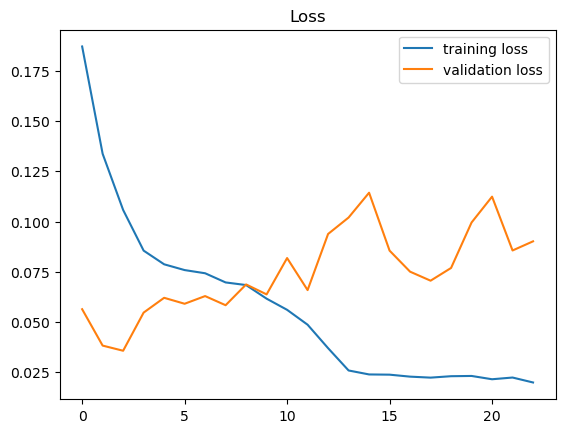

2/2 [==============================] - 0s 3ms/step


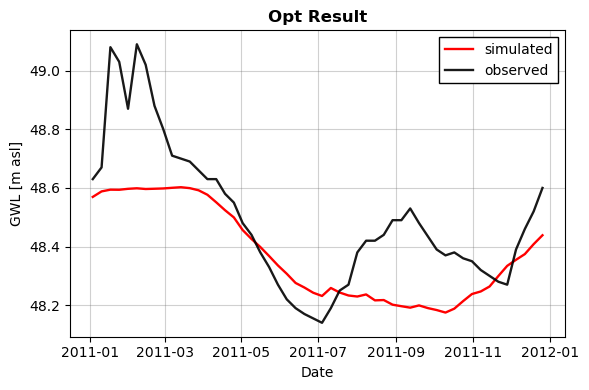

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


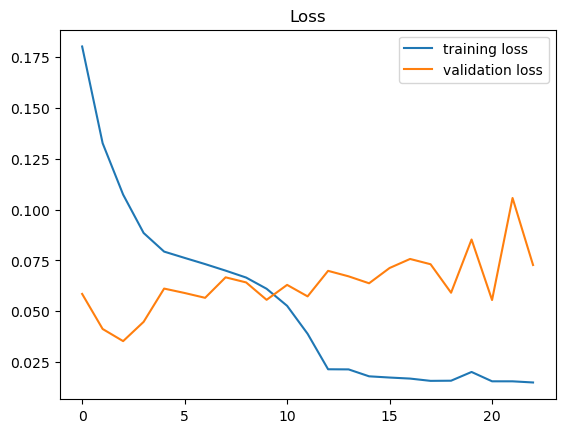

2/2 [==============================] - 0s 3ms/step


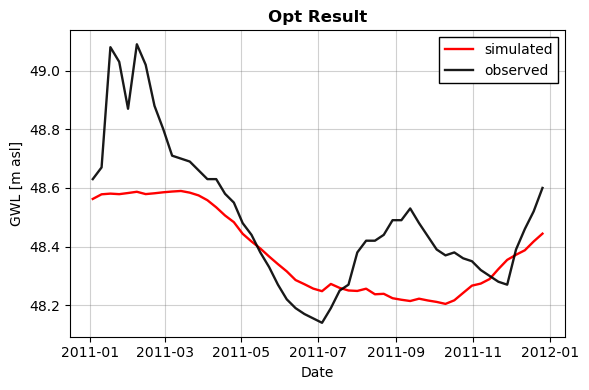

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100


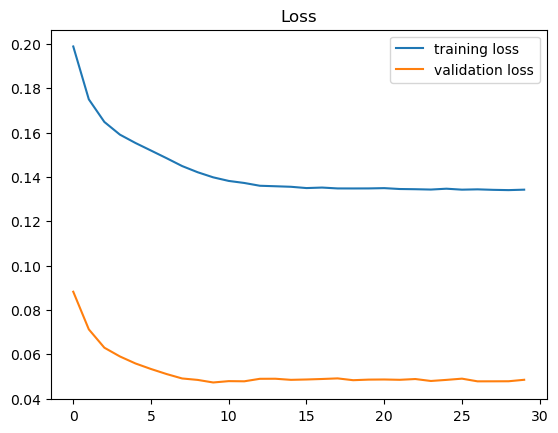

2/2 [==============================] - 0s 3ms/step


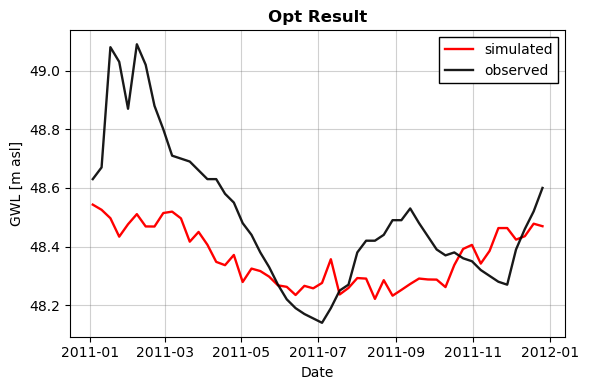

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


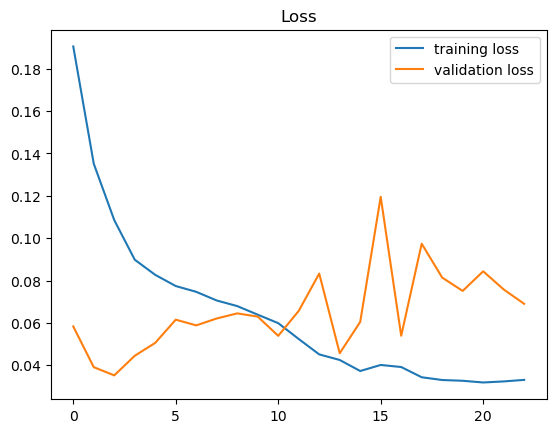

2/2 [==============================] - 0s 3ms/step


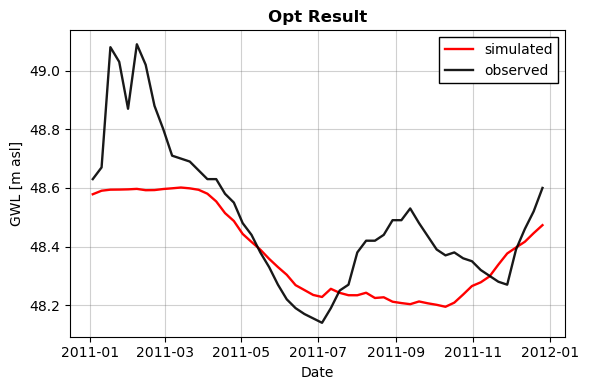

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100


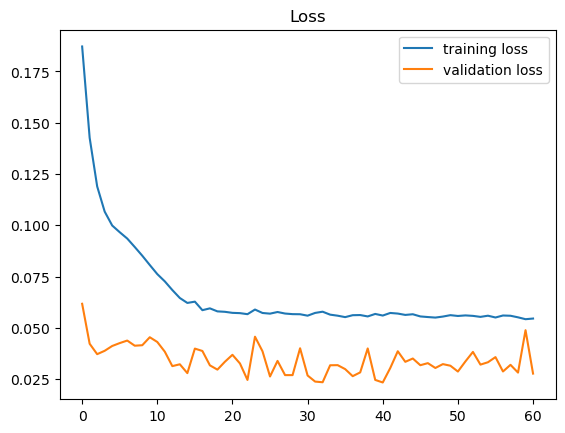

2/2 [==============================] - 0s 3ms/step


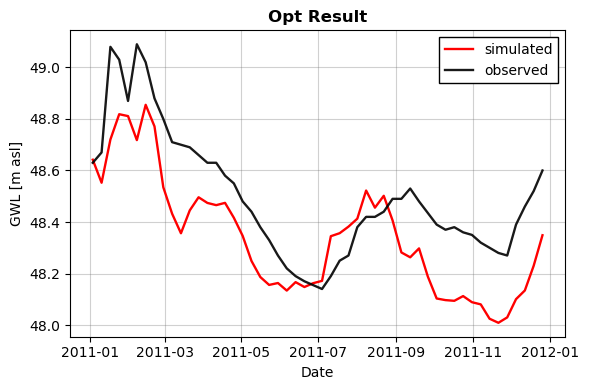

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100


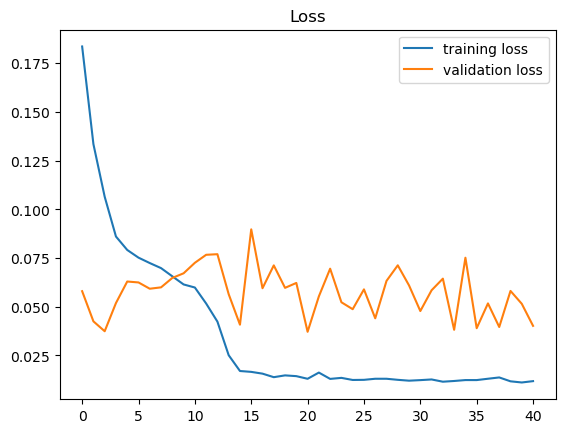

2/2 [==============================] - 0s 3ms/step


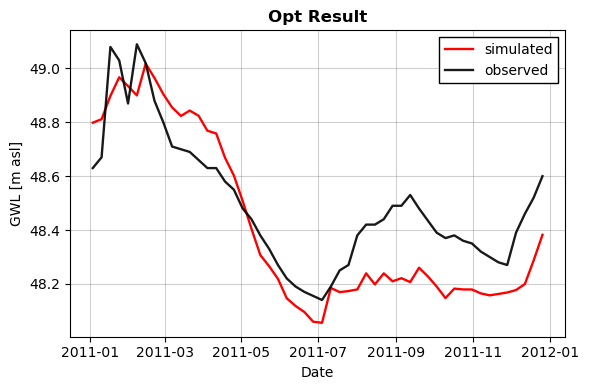

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100


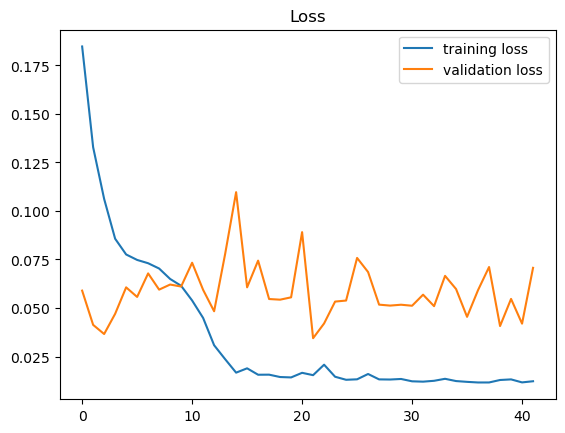

2/2 [==============================] - 0s 3ms/step


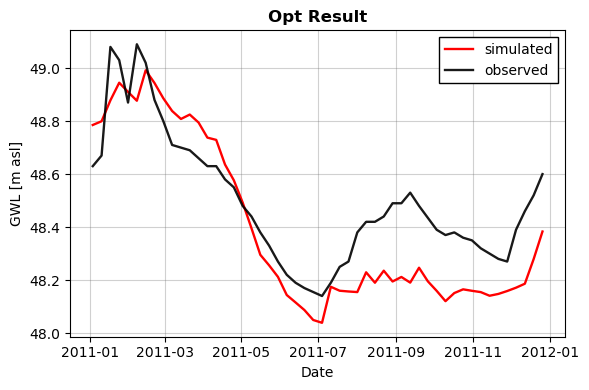

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


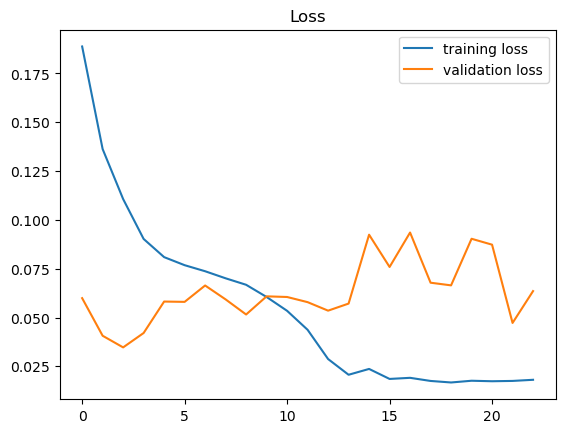

2/2 [==============================] - 0s 3ms/step


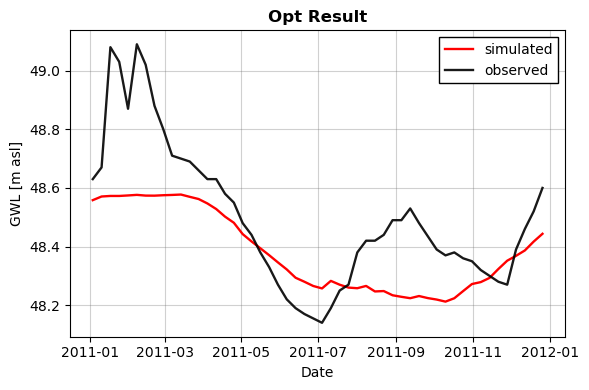

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100


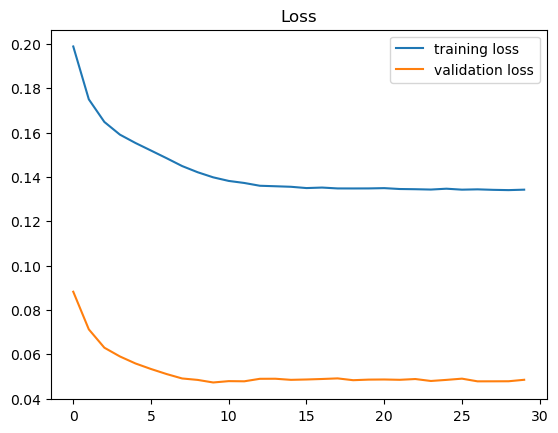

2/2 [==============================] - 0s 3ms/step


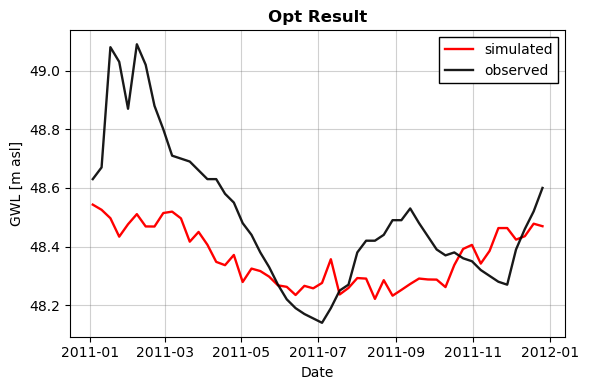

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


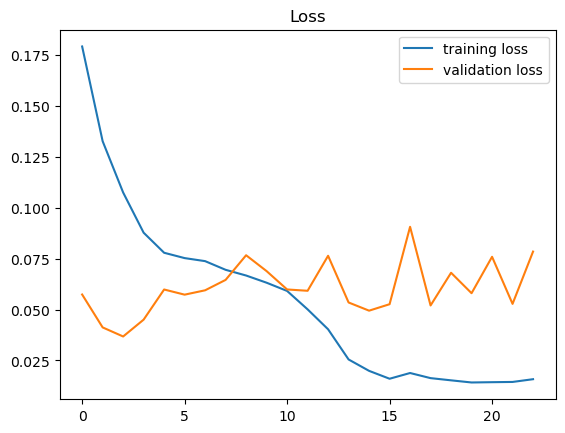

2/2 [==============================] - 0s 3ms/step


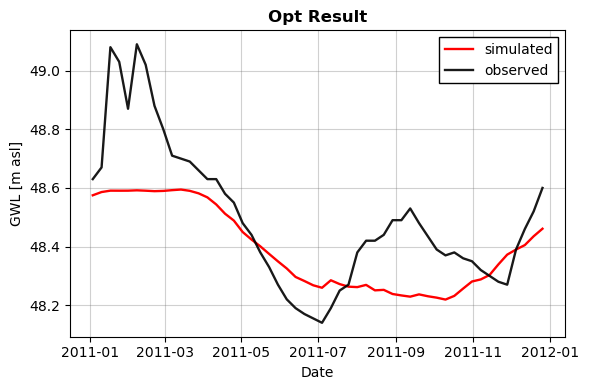

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


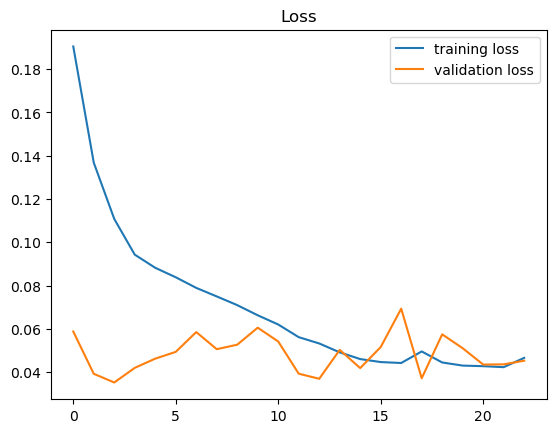

2/2 [==============================] - 0s 3ms/step


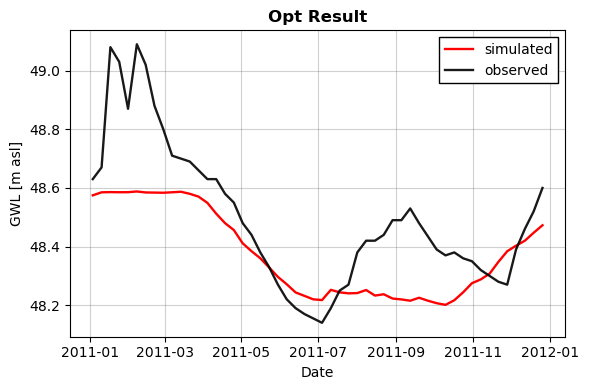

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


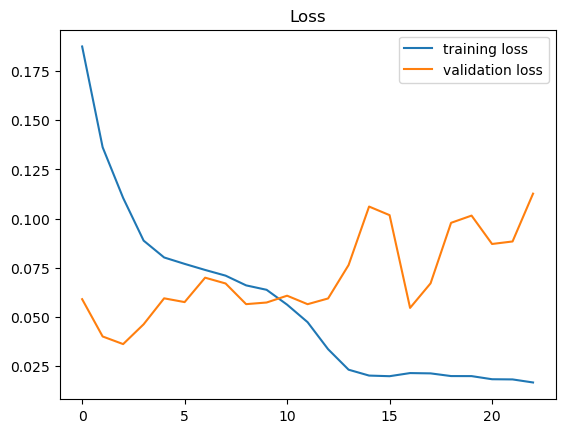

2/2 [==============================] - 0s 3ms/step


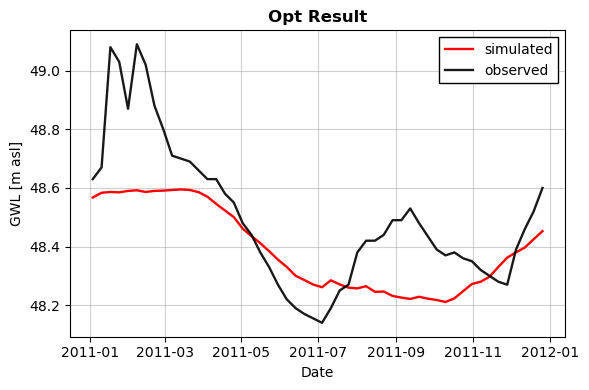

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


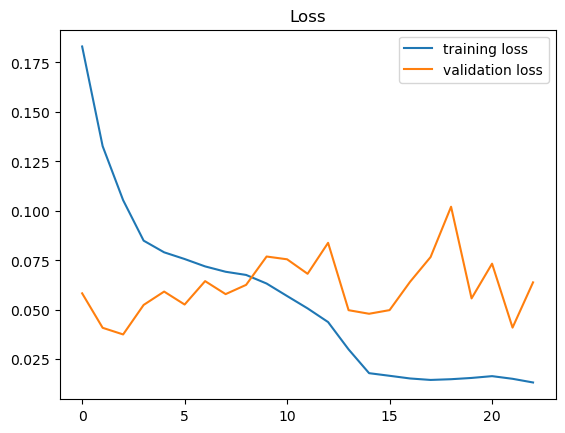

2/2 [==============================] - 0s 3ms/step


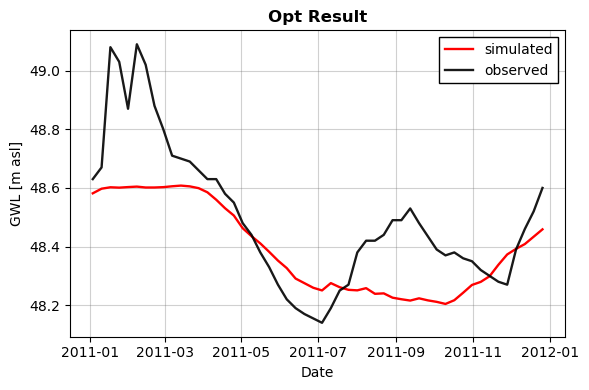

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


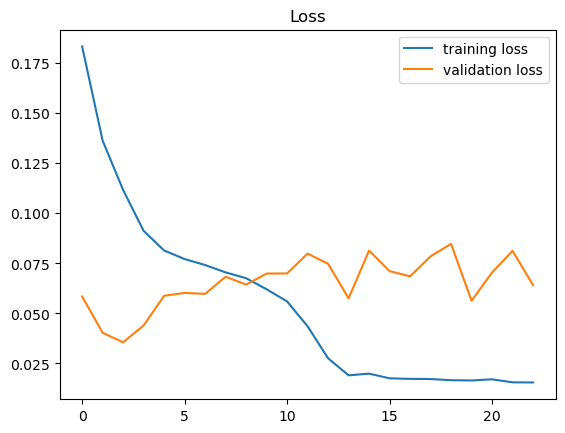

2/2 [==============================] - 0s 9ms/step


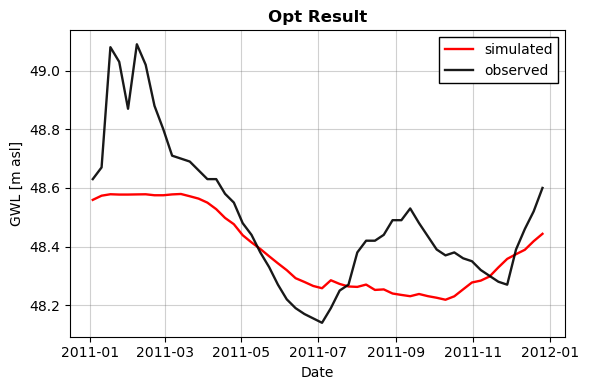

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


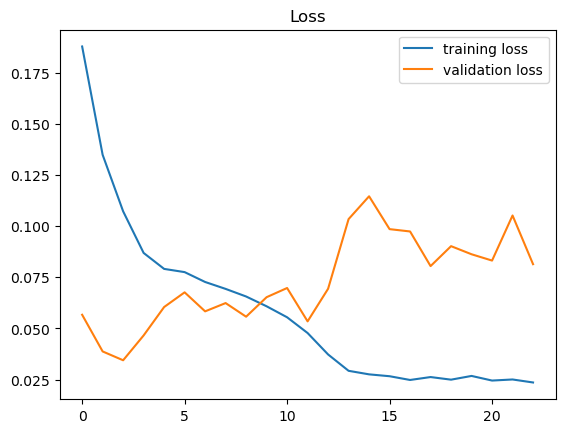

2/2 [==============================] - 0s 3ms/step


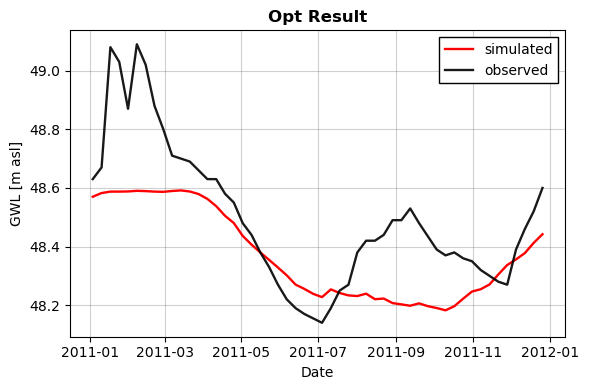

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100


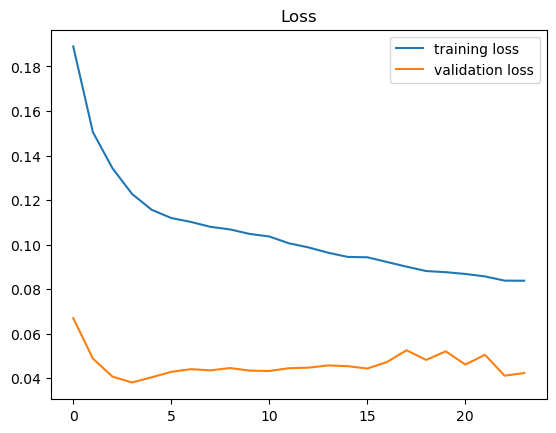

2/2 [==============================] - 0s 3ms/step


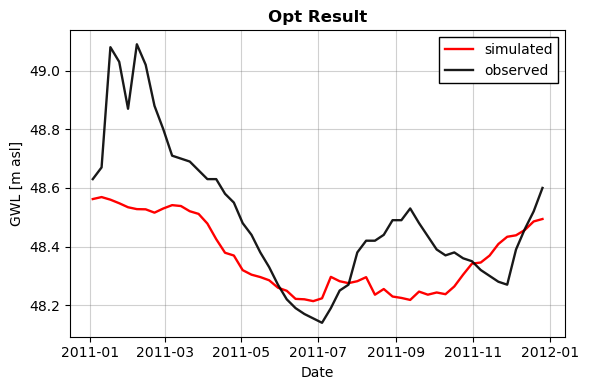

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


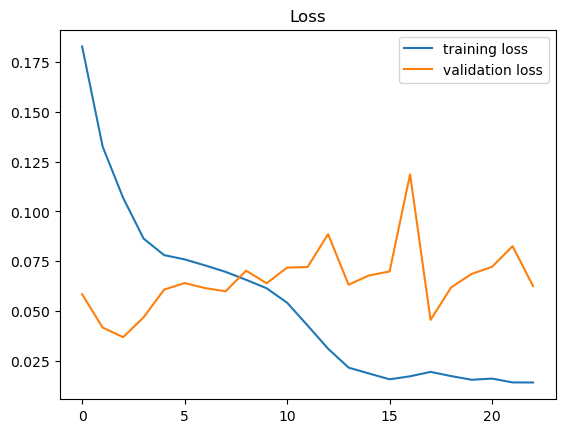

2/2 [==============================] - 0s 3ms/step


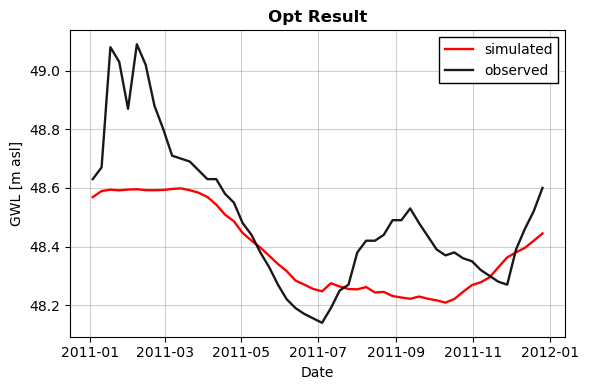

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


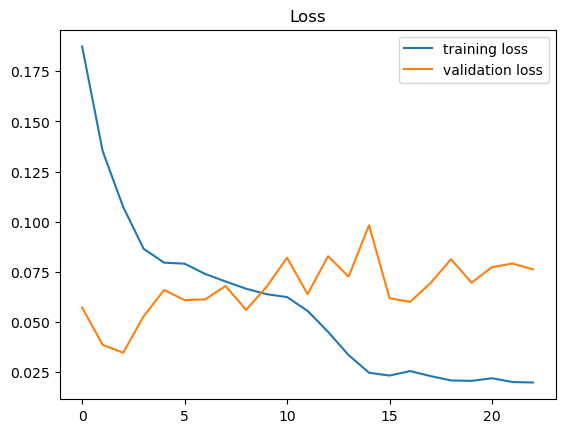

2/2 [==============================] - 0s 3ms/step


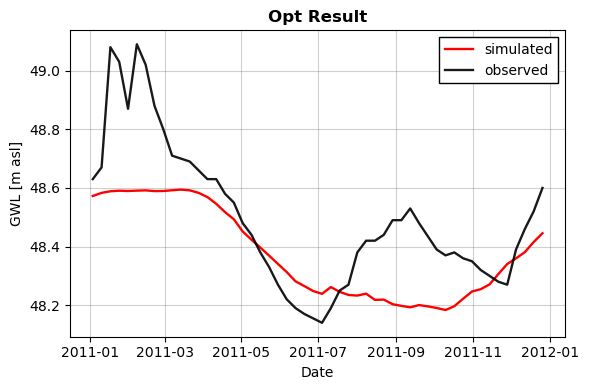

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


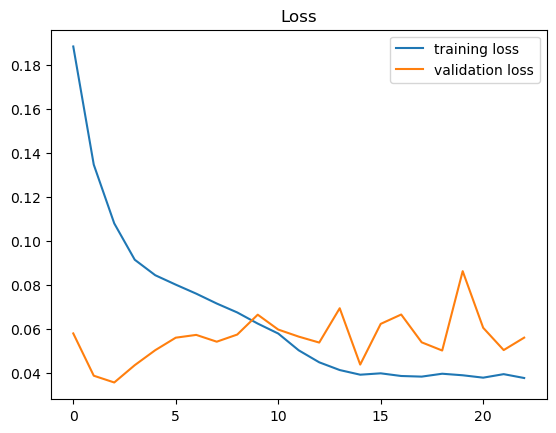

2/2 [==============================] - 0s 4ms/step


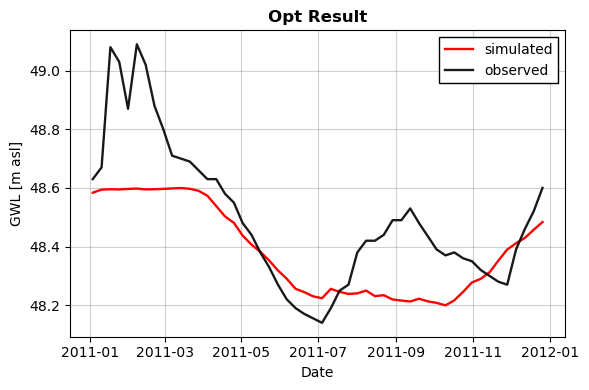

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


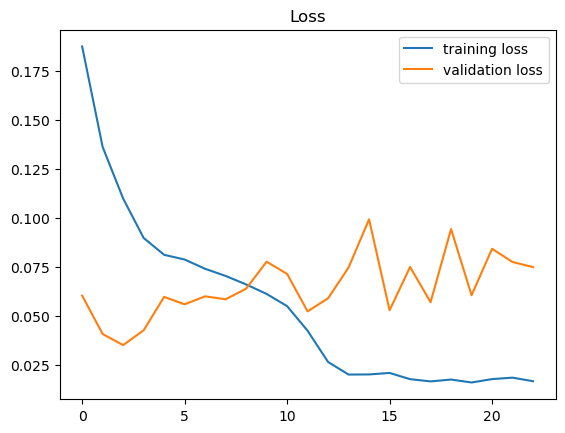

2/2 [==============================] - 0s 3ms/step


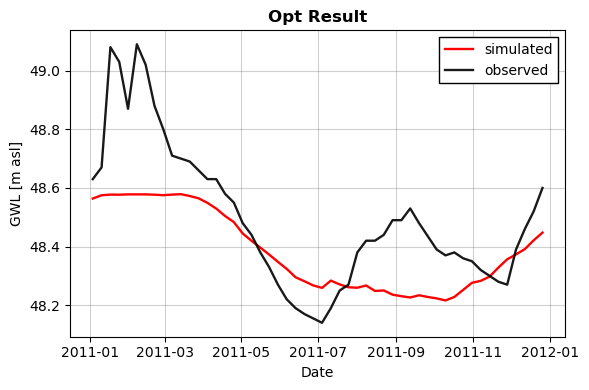

In [9]:
#Hier definieren wir den eigentlichen Optimizer
optimizer = BayesianOptimization(
    f= bayesoptfunction, #Name der Funktion die optimiert wird (s.o. die Funktion die wir geschrieben haben)
    pbounds=pbounds, #Wertebereiche in denen optimiert wird
    random_state=1, #seed
    verbose = 0 # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent, verbose = 2 prints everything
    )

# Save progress: der logger schreibt die Ergbenisse der Iteration in einem json file mit:
logger = JSONLogger(path="./logs.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.set_gp_params(normalize_y=True)

# Create an instance of UtilityFunction for the acquisition function
acquisition_function = UtilityFunction(kind="ei", xi=0.05)

# Start the optimization
optimizer.maximize(
    init_points=5,         # Steps of random exploration (random starting points)
    n_iter=15,             # Steps of Bayesian optimization
    acquisition_function=acquisition_function
)

#Nach abgeschlossener Optimierung wollen wir den besten Wert für n_steps_in (als integer: int(...))auslesen:    
# -> get best values from optimizer

n_steps_in= int(optimizer.max.get("params").get("n_steps_in")) # auch hier wollen wir wieder den integer haben

In [10]:
#beste Iteration anzeigen:
print("\nBEST:\t{}".format(optimizer.max))

#Nachschauen nach welcher Iteration bereits das Maximum erreicht wurde:
beststep = False
step = -1
while not beststep:
    step = step + 1
    beststep = optimizer.res[step] == optimizer.max
print("\nbest step {:.0f} of {:.0f} steps in total".format(step+1, len(optimizer.res)))


BEST:	{'target': -0.025477781068845906, 'params': {'n_steps_in': 49.993913591138856}}

best step 6 of 20 steps in total


Nun wollen wir das Modell mit dem scheinbar optimalen Wert für n_steps_in trainieren und testen. Hierfür brauchen wir fast den gleichen Code wie in der Funktion (bayesoptfunction) oben, nur wenden wir das Modell jetzt auf Testdaten statt Optdaten an:

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100


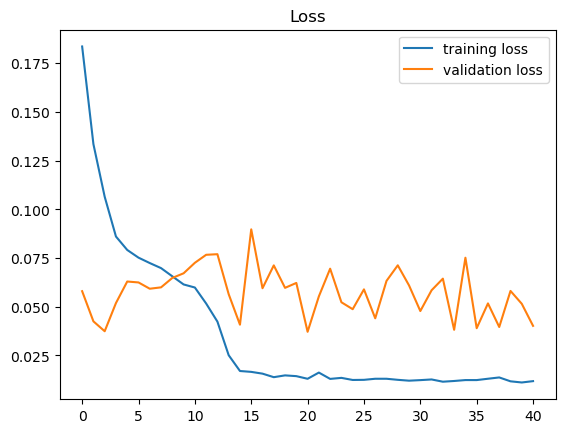

7/7 [==============================] - 0s 3ms/step


In [11]:
# n_steps_in haben wir bereits definiert

#%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Nun folgende die altbekannten Schritte wie im letzten Termin zur Zeitreihenvorhersage.
#%%%%%%%%%%%%%%%%%%%%%%%%%%%

#extend with overlap to be able to fill sequence (n_steps_in) later                                              
StopData_ext = pd.concat([TrainingData.iloc[-n_steps_in:], StopData], axis=0) #takes last steps of TrainingData and combines it with StopData
# OptData_ext = pd.concat([StopData.iloc[-n_steps_in:], OptData], axis=0) #takes last steps of ValidationData and combines it with OptData
TestData_ext = pd.concat([OptData.iloc[-n_steps_in:], TestData], axis=0) #takes last steps of OptData and combines it with TestData

#create scalers and fit to data data (normalize: *_n):
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(TrainingData) # fit on training data, scale all other parts afterwards

scaler_gwl = MinMaxScaler(feature_range=(-1, 1)) 
scaler_gwl.fit(pd.DataFrame(TrainingData['GWL'])) # fit scaler only on GWL for rescaling later

#scale (transform) data
TrainingData_n = scaler.transform(TrainingData)
StopData_ext_n = scaler.transform(StopData_ext)
TestData_ext_n = scaler.transform(TestData_ext)

#Daten in Sequenzen umwandeln:
X_train,Y_train = make_sequences(np.asarray(TrainingData_n), n_steps_in)
X_stop,Y_stop = make_sequences(np.asarray(StopData_ext_n), n_steps_in)
X_test,Y_test = make_sequences(np.asarray(TestData_ext_n), n_steps_in)


#%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Model bauen und trainieren:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%

#set seed
ini=0
seed(ini+872527)
tf.random.set_seed(ini+87747)

#build model
inp = tf.keras.Input(shape=(n_steps_in, X_train.shape[2])) 
lstm = tf.keras.layers.LSTM(32)(inp) 
dense = tf.keras.layers.Dense(30, activation='relu')(lstm) 
output = tf.keras.layers.Dense(1, activation='linear')(dense) 
model = tf.keras.Model(inputs=inp, outputs=output)


#define optimizer
Adam = tf.keras.optimizers.Adam(learning_rate=1E-3, epsilon=1E-3, clipnorm=True)

#compile the model
model.compile(loss='mse', optimizer=Adam, metrics=['mse'])

#define early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights = True)

#train the model
history = model.fit(X_train, Y_train,validation_data=(X_stop, Y_stop), epochs=100, verbose=3,
                    batch_size=32, callbacks=[es])

#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title('Loss')
plt.show()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Testen 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%

#Modell testen mit X_test
sim = model.predict(X_test)

#rescale simulated and observed values
sim = scaler_gwl.inverse_transform(sim)  # retransform to original scale
obs = scaler_gwl.inverse_transform(Y_test.reshape(-1,1))

Nun berechnen wir wieder Fehlerwerte und Plotten das Ergebnis (analog zu oben):

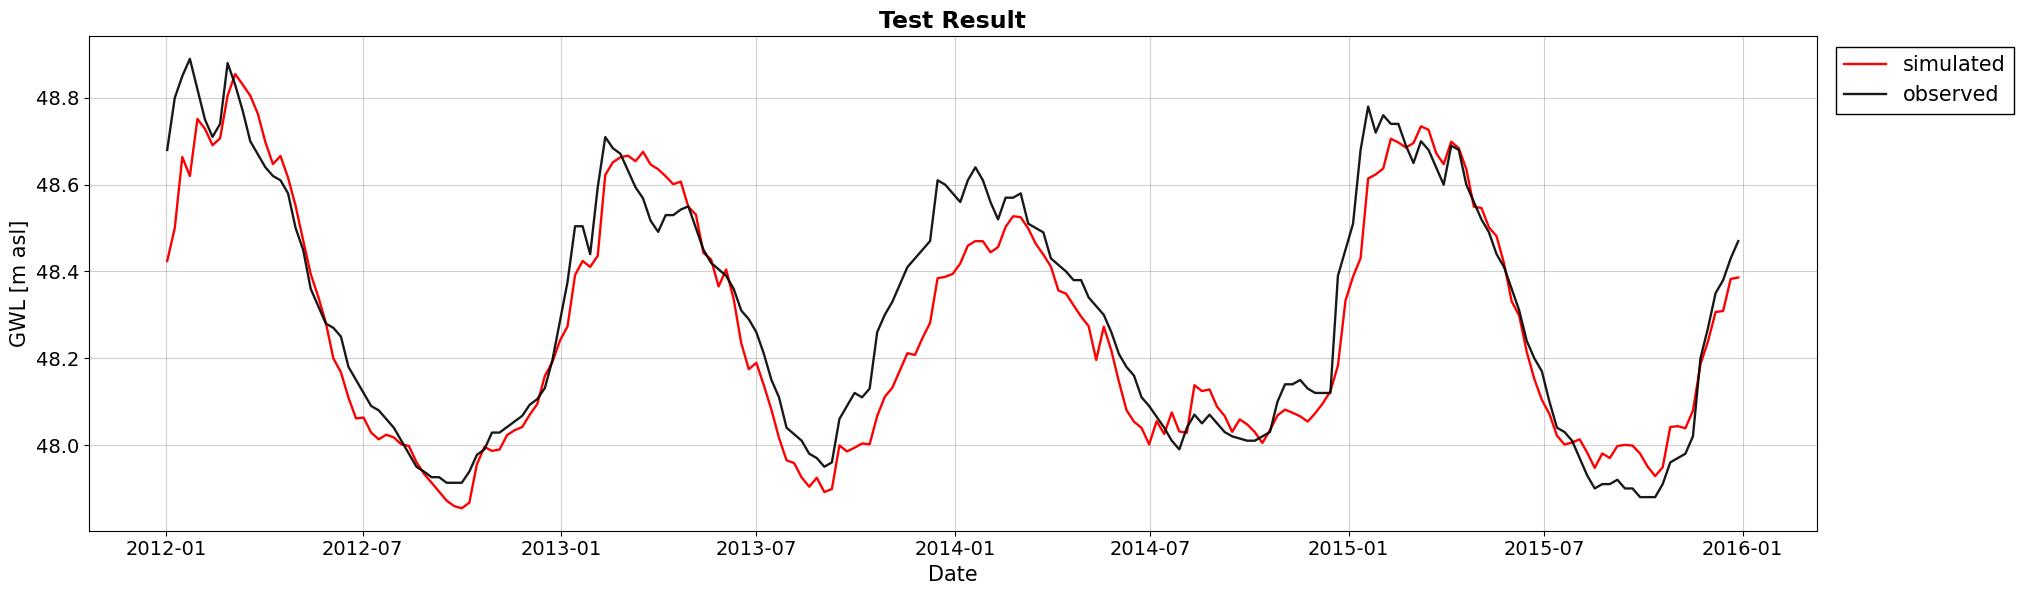

n_steps_in = 49 weeks


,NSE,RMSE,r,Bias
0,0.896371,0.088922,0.955832,-0.036084


In [12]:
from scipy import stats

#Nash-Sutcliffe-Efficiency: NSE
NSE = 1 - ((np.sum((sim-obs) ** 2)) / (np.sum((obs - np.mean(obs)) ** 2)))

#Root Mean Squared Error
RMSE =  np.sqrt(np.mean((sim-obs) ** 2))

#Pearson r
r = stats.pearsonr(sim[:,0], obs[:,0])
r = r[0] #r

#Bias
Bias = np.mean(sim-obs)

scores = pd.DataFrame(np.array([[NSE, RMSE, r, Bias]]),
                      columns=['NSE','RMSE','r','Bias'])

#Plot testset Simulation
plt.figure(figsize=(20,6))
plt.plot(TestData.index, sim, 'r', label ="simulated", linewidth = 1.7)
plt.plot(TestData.index, obs, 'k', label ="observed", linewidth=1.7,alpha=0.9)

plt.title("Test Result", size=17,fontweight = 'bold')
plt.ylabel('GWL [m asl]', size=15)
plt.xlabel('Date',size=15)
plt.legend(fontsize=15,bbox_to_anchor=(1.12, 1),loc='upper right',fancybox = False, framealpha = 1, edgecolor = 'k')
plt.tight_layout()
plt.grid(visible=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print("n_steps_in = {:.0f} weeks".format(n_steps_in))
scores.head()

### Aufgabe 1: zusätzlichen Hyperparameter optimieren

Wir möchten neben n_steps_in nun auch die Anzahl der LSTm units im LSTM Layer optimieren. Der Parameter soll *n* heißen.

Ändere den obigen Code so, dass beide Parameter optimiert werden. nutze dafür folende Anleitung:  
* Füge *n* der Funktion *bayesoptfunction* als Input parameter hinzu (gnau wie n_steps_in):
```python
    def bayesoptfunction(n_steps_in,n): 
```
* Wandle *n* zu Beginn der Funktion in einen integer um (genau wie n_steps_in)
* Füge *n* an entsprechener Stelle im LSTM Layer ein
```python
    ...(units=n)... 
```
* Optimiere *n* für einen Wertebereich von 10 bis 50 (Parameter dem pbounds Dict hinzufügen)
```python
pbounds = {'A': (AMin,AMax),
           'B': (BMin,BMax)           } #etc...
```
* Entnehme den besten Wert für n dem optimizer mit folgendem Befehl: 
```python
n = int(optimizer.max.get("params").get("n"))* 
```
* Übernehme den gefundenen Wert für *n* auch im Code für das Model, welches für die Testdaten verwendet wird

Tipp: Entweder du änderst direkt den Code den du oberhalb findest (dann am besten das Notebook als Kopie abspeichern), oder kopiere dir den Code nach unten und erstellst neue Zellen. 

### Aufgabe 2: Einfaches Modell Ensemble

Alle ANN werden mit (quasi)zufälligen Werten der Gewichte initialisiert. Um das Modell reproduzierbar zu halten, setzen wir immer den random seed vor jedem Durchlauf. Dies können wir aber auch nutzen um ein Ensemble zu erstellen, welches uns zeigt wie stark das Ergebnis vom random seed abhängt. ANstatt nun also immer den gleichen seed zu wählen, definieren wir mehrere Modelle mit unterschiedlichen Initialisierungen. 

Schreibe daher die übernächste Notebookzelle (Nur eine Kopie des Codes von oben) als **Schleife** bei der der Parameter *ini* von 0 bis 4 (also 5 verschiedene Werte: 0,1,2,3,4) varriert wird. Vergiss dafür nicht alle Zeilen nach dem Einrichten der Schleife einzurücken. 

Wir definieren zuvor die Variable *sim_all* in die die Ergebnisse aller Durchläufe jeweils als Spalte eingefügt werden sollen. 

In [13]:
sim_all = np.zeros((Y_test.shape[0],5)) #das nennt man preallocation, 
#weiter unten im Code soll nachdem die Schleife eingefügt wurde bei jedem Durchgang 
#das Ergebnis folgendermaßen abegelegt werden: sim_all[:,ini] = sim

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100


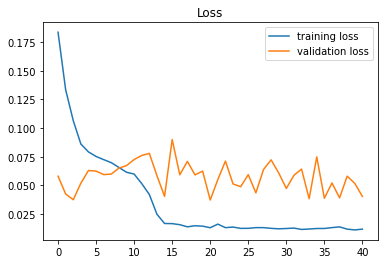

In [14]:

ini=0# Hier sollte die Schleife beginnen (statt ini=0)
seed(ini+872527)
tf.random.set_seed(ini+87747)

#build model
inp = tf.keras.Input(shape=(n_steps_in, X_train.shape[2])) 
lstm = tf.keras.layers.LSTM(32)(inp) 
dense = tf.keras.layers.Dense(30, activation='relu')(lstm) 
output = tf.keras.layers.Dense(1, activation='linear')(dense) 
model = tf.keras.Model(inputs=inp, outputs=output)

#define optimizer
Adam = tf.keras.optimizers.Adam(learning_rate=1E-3, epsilon=1E-3, clipnorm=True)

#compile the model
model.compile(loss='mse', optimizer=Adam, metrics=['mse'])

#define early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights = True)

#train the model
history = model.fit(X_train, Y_train,validation_data=(X_stop, Y_stop), epochs=100, verbose=3,
                    batch_size=32, callbacks=[es])

#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title('Loss')
plt.show()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Testen 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%

#Modell testen mit X_test
sim = model.predict(X_test)

#rescale simulated and observed values
sim = scaler_gwl.inverse_transform(sim)  # retransform to original scale
obs = scaler_gwl.inverse_transform(Y_test.reshape(-1,1))

#hier sim_all entsprechend dem Hinweis oben spaltenweise füllen


Wenn ihr erfolgreich seid, könnt ihr die nächsten Zellen einfach laufen lassen ohne etwas zu ändern. Am Ende sollten ihr einen Plot herausbekommen, der euch alle Modelle sowie den Ensemblemittelwert zeigt. 

C:\Anaconda3\envs\gda2\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


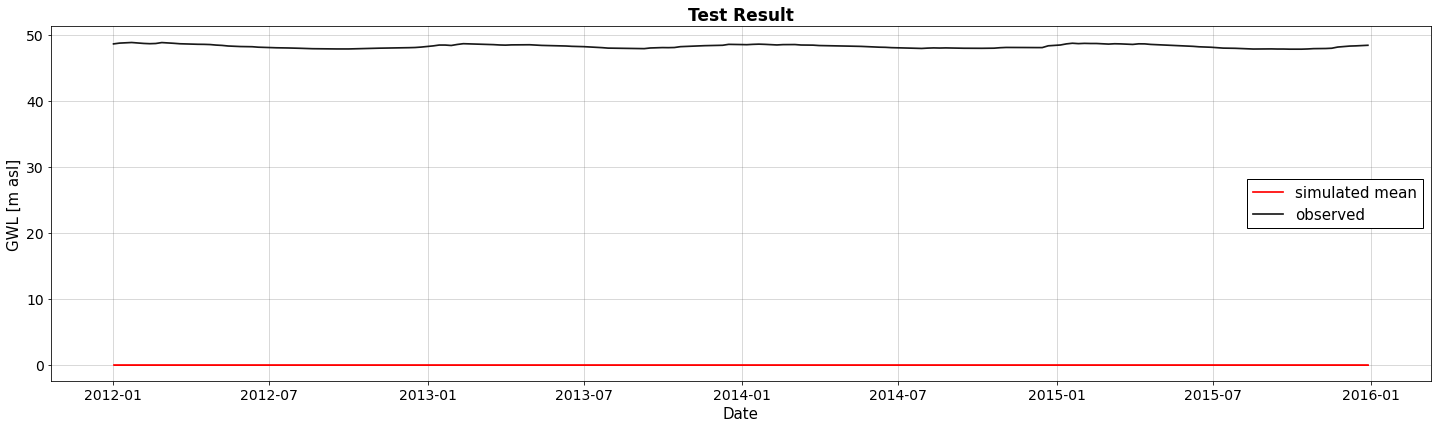

,NSE,RMSE,r,Bias
0,-30578.452188,48.304051,NaN,-48.303261


In [15]:
sim_mean = np.mean(sim_all,axis = 1).reshape(-1,1) #wir berechnen die Fheler für den Mittelwert des Ensembles

#Nash-Sutcliffe-Efficiency: NSE
NSE = 1 - ((np.sum((sim_mean-obs) ** 2)) / (np.sum((obs - np.mean(obs)) ** 2)))

#Root Mean Squared Error
RMSE =  np.sqrt(np.mean((sim_mean-obs) ** 2))

#Pearson r
r = stats.pearsonr(sim_mean[:,0], obs[:,0])
r = r[0] #r

#Bias
Bias = np.mean(sim_mean-obs)

scores = pd.DataFrame(np.array([[NSE, RMSE, r, Bias]]),
                      columns=['NSE','RMSE','r','Bias'])

#Plot testset Simulation
plt.figure(figsize=(20,6))

for i in range(5):
    plt.plot(TestData.index, sim_all[:,i], 'r', label = None, linewidth = 1, alpha = 0.5)

plt.plot(TestData.index, sim_mean, 'r', label ="simulated mean", linewidth = 1.7)
plt.plot(TestData.index, obs, 'k', label ="observed", linewidth=1.7,alpha=0.9)

plt.title("Test Result", size=17,fontweight = 'bold')
plt.ylabel('GWL [m asl]', size=15)
plt.xlabel('Date',size=15)
plt.legend(fontsize=15,fancybox = False, framealpha = 1, edgecolor = 'k')
plt.tight_layout()
plt.grid(visible=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

scores.head()